# TensorFlow on Textual Data

This notebook contains the code to predict the authors of texts using a convolutional neural network. Three different data representations are used.
* First, the texts are treated as simple sequences of their words.
* Second, the texts are splitted into its sentences. Then, the author probabilities on these sentences vote on the text author.
* Third, the texts are represented by a three-dimensional tensor (with an axis for sentence, word and embedding), for 3D convolution.

These are the packages used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
import collections
import re
import random
import sqlite3

---
# 1. Text Preproccessing

### Import
Load data from sqlite file into pandas dataframe.

In [2]:
conn = sqlite3.connect('/Users/desiredewaele/Google Drive/Datasets/rawData.sqlite')
speeches = pd.read_sql("select date, president, text from Speeches where speech is 'Weekly Address'", conn)
speeches = speeches[speeches.president.str.contains('Barack Obama|William J. Clinton|George W. Bush', regex=True)]
speeches.reset_index(inplace=True, drop=True)
speeches.head()

,date,president,text
0,"January 9, 2016",Barack Obama,"Hi, everybody. Seven years ago, the American a..."
1,"January 30, 2016",Barack Obama,"Hi, everybody. As I said in my State of the Un..."
2,"February 6, 2016",Barack Obama,"Hi, everybody. One of the things that makes Am..."
3,"February 27, 2016",Barack Obama,"Hi, everybody. This week, we continued our mis..."
4,"January 23, 2016",Barack Obama,"Hi, everybody. When I took office 7 years ago ..."


### Date Formatting
Get the dates in a sortable format.

In [3]:
def getDates(date):
    date = dt.datetime.strptime(date, '%B %d, %Y')
    date = dt.datetime.strftime(date, '%Y-%m-%d')
    return date

In [4]:
speeches.date = speeches.date.apply(getDates)
speeches.sort_values('date', inplace=True)
speeches.reset_index(drop=True, inplace=True)
speeches.head()

,date,president,text
0,1993-02-06,William J. Clinton,Good morning. This is Bill Clinton. And this m...
1,1993-02-13,William J. Clinton,"Good afternoon, my fellow Americans. On Wednes..."
2,1993-02-20,William J. Clinton,"This is Bill Clinton. As you know, this week I..."
3,1993-02-27,William J. Clinton,Good morning. Before I talk with you about our...
4,1993-03-06,William J. Clinton,Good morning. We've come a long way together i...


### A. Text Data
First, the texts are treated as simple sequences of their words.

In [5]:
def getFormatText(s):
    s = s.lower()                         # Change text to lowercase
    s = re.sub('\(\.*\)|\[\.*\]', '', s)  # Removes all bracket parts
    s = re.sub('[^(a-z)]| ', ' ', s)      # Change all not-text to spaces
    s = re.sub(' +',' ', s)               # Remove all redundant spaces
    s = s.strip()                         # Remove outer whitespace
    return s

In [6]:
texts = pd.DataFrame({'text': speeches.text.apply(getFormatText), 'president': speeches.president})
texts.head()

,president,text
0,William J. Clinton,good morning this is bill clinton and this mor...
1,William J. Clinton,good afternoon my fellow americans on wednesda...
2,William J. Clinton,this is bill clinton as you know this week i s...
3,William J. Clinton,good morning before i talk with you about our ...
4,William J. Clinton,good morning we ve come a long way together in...


### B. Sentence Data
Second, the texts are splitted into its sentences. Later, the author probabilities on the sentences of a given text will vote on the author of that text.

In [7]:
def getSentences(text):
    sentences = np.array(re.split('\. |\! |\? |\; |\: |\" ', text))
    for i, s in enumerate(sentences):
        sentences[i] = getFormatText(s)
    return sentences

In [8]:
sentence = speeches.text.apply(getSentences).apply(pd.Series, 1).stack()
presidents = speeches.president[sentence.index.get_level_values(0)].values
sentences = pd.DataFrame({'sentence': sentence, 'president': presidents})
sentences.head()

president                                           sentence
0 0  William J. Clinton                                       good morning
  1  William J. Clinton                               this is bill clinton
  2  William J. Clinton  and this morning on my first radio address i w...
  3  William J. Clinton  how we can build a strong and growing economy ...
  4  William J. Clinton  lately we ve had some good news about our economy

### C. Tensor Data

Third, the texts are represented by a three-dimensional tensor for 3D convolution.
* Axis 1 will represent the sequence of sentences within a text.
* Axis 2 will represent the sequence of words within a sentence.
* Axis 3 will represent the embedding representation of a particular word (see later). 

In [9]:
tensor = speeches.text.apply(getSentences).apply(pd.Series)
tensor = tensor.fillna('').applymap(lambda x: x.split())
tensor.head(2)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,"[good, morning]","[this, is, bill, clinton]","[and, this, morning, on, my, first, radio, add...","[how, we, can, build, a, strong, and, growing,...","[lately, we, ve, had, some, good, news, about,...","[our, business, productivity, is, up]","[our, people, are, producing, more, at, lower,...","[and, lower, interest, rates, are, giving, peo...","[now, that, change, is, in, the, air, people, ...","[consumer, confidence, is, up, and, the, finan...",...,[],[],[],[],[],[],[],[],[],[]
1,"[good, afternoon, my, fellow, americans]","[on, wednesday, night, i, will, present, my, p...","[this, morning, i, want, to, talk, with, you, ...","[as, i, have, traveled, our, country, over, th...","[that, theme, is, the, need, for, change]","[bold, comprehensive, change, to, reverse, the...","[over, the, last, years, while, the, middle, c...","[higher, deficits, came, with, lower, taxes, o...","[and, those, deficits, forced, government, to,...","[good, families, in, embattled, neighborhoods,...",...,[],[],[],[],[],[],[],[],[],[]


---
# 2. Embedding with Word2Vec

Given a collection of texts with n different words, one can imagine an n-dimensional vector space in which every word could be represented by one-hot encoding - i.e. a value of 1 for the given word dimension, and a value of 0 for all other dimensions.

Embeddings are representations of words in a reduced vector space, not with n dimensions, but with, say 100 or 200. They are trained in such a way that words with related meanings have smaller distances in between them, whereas unrelated words will lie widely apart in the vector space.

---
## Build Dataset

In [10]:
words = sentences.sentence.str.split().values
words = np.array([item for sublist in words for item in sublist])

This function builds the dataset. 
* Counts stores the 15000 most occuring words with their number of occurences in a tuple.
* Dictionary stores the same words with their index in count.
* Reverse Dictionary swaps the key value pairs in dictionary.
* Data gets the index in dictionary for all words in the corpus.

In [11]:
def buildDataset(words, VOCAB=15000):
    
    # Count [['UNK', 52101], ('the', 43154), ('to', 33493) ...]
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(VOCAB - 1))
    
    # Dictionary {'UNK': 0, 'the': 1, 'to': 2, ...}
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # Reverse Dictionary {0: 'UNK', 1: 'the', 2: 'to', ...}
    rDictionary = dict(zip(dictionary.values(), dictionary.keys())) 

    # Data [61, 124, 13, 14, ...] Index in dictionary
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    
    return data, count, dictionary, rDictionary

In [12]:
data, count, dictionary, rDictionary = buildDataset(words)

In [13]:
print('Five most common words:', count[:5])
print('Five first words in texts:', words[:8])
print('Five first words count index:', data[:8])
del words

('Five most common words:', [['UNK', 595], (u'the', 43182), (u'to', 33498), (u'and', 32856), (u'of', 22917)])
('Five first words in texts:', array([u'good', u'morning', u'this', u'is', u'bill', u'clinton', u'and',
       u'this'], 
      dtype='<U25'))
('Five first words count index:', [61, 124, 13, 14, 103, 2632, 3, 13])


---
## Generate Training Batches
The idea is to create word pairs of data and label words. Every word of the data set (or batch) is put together with a close occuring word in a tuple. Windows is the number of words to consider as a label left and right of the query word. Skips is the number of times we reuse a word to generate a label, so this should be two times the window.

<img src="img/skipgramdata.png" style="width: 600px;"/>

In [14]:
data_index = 0

def generateBatch(BATCH, SKIPS, WINDOW):
    global data_index
    assert BATCH % SKIPS == 0
    assert SKIPS <= 2 * WINDOW
    batch = np.ndarray(shape=(BATCH), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH, 1), dtype=np.int32)
    span = 2 * WINDOW + 1
    buffer = collections.deque(maxlen=span) # Create enhanced array
    for _ in range(span): # Add count index of every data word in span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(BATCH // SKIPS):
        target = WINDOW  # target label at the center of the buffer
        targets_to_avoid = [ WINDOW ]
        for j in range(SKIPS):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * SKIPS + j] = buffer[WINDOW]
            labels[i * SKIPS + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [15]:
print('data:', [rDictionary[di] for di in data[:8]])

for SKIPS, WINDOW in [(4, 2), (2, 1)]:
    data_index = 0
    batch, labels = generateBatch(8, SKIPS, WINDOW)
    print('\nWith SKIPS = %d and WINDOW = %d:' % (SKIPS, WINDOW))
    print('    batch:', [rDictionary[bi] for bi in batch])
    print('    labels:', [rDictionary[li] for li in labels.reshape(8)])

('data:', [u'good', u'morning', u'this', u'is', u'bill', u'clinton', u'and', u'this'])

With SKIPS = 4 and WINDOW = 2:
('    batch:', [u'this', u'this', u'this', u'this', u'is', u'is', u'is', u'is'])
('    labels:', [u'good', u'morning', u'is', u'bill', u'this', u'bill', u'morning', u'clinton'])

With SKIPS = 2 and WINDOW = 1:
('    batch:', [u'morning', u'morning', u'this', u'this', u'is', u'is', u'bill', u'bill'])
('    labels:', [u'this', u'good', u'is', u'morning', u'bill', u'this', u'clinton', u'is'])


---
## Train Embeddings with Skip-Gram Model

Setting hyperparameters for skip-gram model. We pick a random validation set to sample nearest neighbors.

In [17]:
BATCH = 200
EMBED = 128
WINDOW = 10
STEPS = 200001
VOCAB = 15000
RATE = 1.0
NEGSAMPLES = 20 # Number of negative examples to sample.
VALIDEXAMPLES = np.array([dictionary[x] for x in ['france', 'mother', 'week', 'america', 'washington']])
#np.array(random.sample(population=range(100), k=5))

In [18]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfTrainX = tf.placeholder(shape=[BATCH], dtype=tf.int32)
    tfTrainY = tf.placeholder(shape=[BATCH, 1], dtype=tf.int32)
    tfValidX = tf.constant(VALIDEXAMPLES, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([VOCAB, EMBED], -1.0, 1.0)) 
    weights = tf.Variable(tf.truncated_normal([VOCAB, EMBED], stddev=1.0 / np.sqrt(EMBED)))
    biases = tf.Variable(tf.zeros([VOCAB]))

    # Look up embeddings and compute the softmax loss, using a sample of the negative labels each time
    embed = tf.nn.embedding_lookup(embeddings, tfTrainX)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=weights, biases=biases, 
        inputs=embed, labels=tfTrainY, num_sampled=NEGSAMPLES, num_classes=VOCAB))

    # Optimizing embeddings, weights and biases
    optimizer = tf.train.AdagradOptimizer(RATE).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    normEmbeddings = embeddings / tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    validEmbeddings = tf.nn.embedding_lookup(normEmbeddings, tfValidX)
    similarity = tf.matmul(validEmbeddings, tf.transpose(normEmbeddings))

In [19]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    averageLoss = 0
    for step in range(STEPS):
        batchX, batchY = generateBatch(BATCH, WINDOW*2, WINDOW)
        _, l = session.run([optimizer, loss], {tfTrainX: batchX, tfTrainY: batchY})
        averageLoss += l
        if step % 50000 == 0:
            averageLoss /= 50000 if step > 0 else 1
            print('\nAverage loss at step {}: {}'.format(step, averageLoss))
            averageLoss = 0
            
            sim = similarity.eval()
            for i in range(len(VALIDEXAMPLES)):
                nearest = (-sim[i, :]).argsort()[1:8+1] # 8 nearest neighbors
                log = 'Nearest to {}:'.format(rDictionary[VALIDEXAMPLES[i]])
                for k in range(len(nearest)):
                    log = '{} {},'.format(log, rDictionary[nearest[k]])
                print(log)
    finalEmbeddings = normEmbeddings.eval()


Average loss at step 0: 6.05821895599
Nearest to france: hovering, overburdened, plan, refinance, precondition, treaties, attend, grocery,
Nearest to mother: curbing, thunderstorm, updating, bay, refill, sharon, clinic, sequester,
Nearest to week: jane, spared, trading, dorgan, diffusion, expects, klobuchar, standing,
Nearest to america: deficit, consumption, refused, rewrite, grind, construct, succumbing, timing,
Nearest to washington: deliver, ginsburg, expressing, scale, encyclopedias, government, allotted, circulating,

Average loss at step 50000: 3.01590204426
Nearest to france: hovering, refinance, precondition, overburdened, grocery, hey, indicated, desert,
Nearest to mother: leveraged, every, curbing, gains, american, detention, desensitized, arctic,
Nearest to week: morning, listening, good, marble, thank, combines, entrant, rehab,
Nearest to america: s, world, grocer, is, interrogated, economy, receded, tatters,
Nearest to washington: anymore, standoff, ginsburg, expressing,

---
## Visualize Embeddings

In [20]:
def plotWithLabels(low_dim_embs, labels, filename='img/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.savefig(filename)
    plt.show()

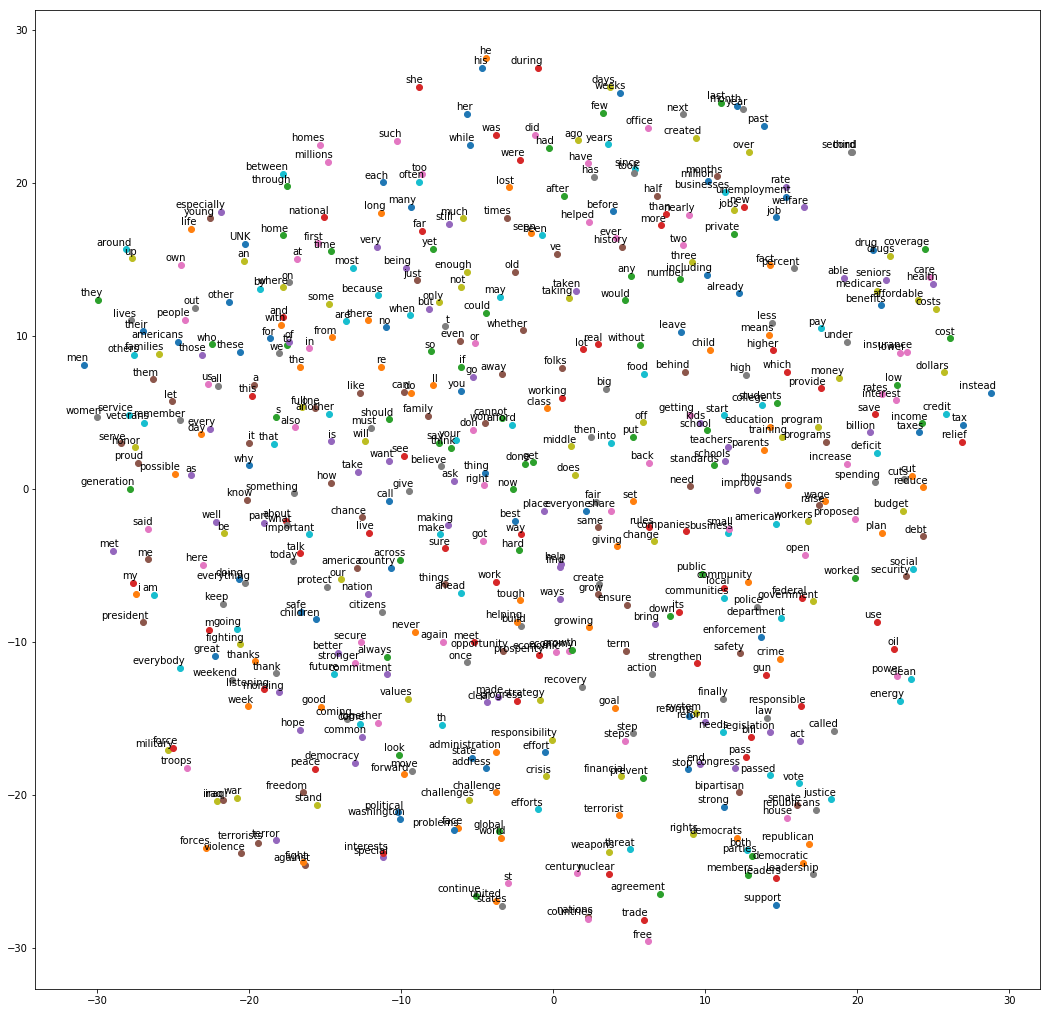

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(finalEmbeddings[:500, :]) # Plot only 500
labels = [rDictionary[i] for i in xrange(500)]
plotWithLabels(low_dim_embs, labels)

In [22]:
np.save('/Users/desiredewaele/Google Drive/Datasets/embeddings.npy', finalEmbeddings) 

---
# 3. Classify Texts with Embeddings

---
## Gather Embed IDs en padding

In [ ]:
finalEmbeddings = np.load('/Users/desiredewaele/Google Drive/Datasets/embeddings.npy')

In [ ]:
textLength = max(texts.text.apply(lambda x: len(x.split())))
sentenceLength = max(sentences.sentence.apply(lambda x: len(x.split())))

print 'The longest text contains {} words.'.format(textLength)
print 'The longest sentence contains {} words.'.format(sentenceLength)

In [ ]:
def getEmbed(words):
    ids = np.empty(words.size, int)
    for i, word in enumerate(words):
        ids[i] = dictionary[word] if word in dictionary else 0
    return ids
    
def pad(text, textlength):
    words = np.array(text.split())
    ids = getEmbed(words)
    pad = np.zeros(textlength - len(words), int)
    return np.append(ids, pad)

In [ ]:
dataT = pd.DataFrame(texts.text.apply(lambda x: pad(x, textLength)).tolist(), index=texts.index)
dataS = pd.DataFrame(sentences.sentence.apply(lambda x: pad(x, sentenceLength)).tolist(), index=sentences.index)
print dataT.shape
print dataS.shape

In [ ]:
dataT.tail()

In [ ]:
labelsT = texts.president
labelsT.tail()

In [ ]:
dataS.tail()

In [ ]:
labelsS = sentences.president
labelsS.tail()

---
## Data Preparation

### Label One-hot Encoding

In [ ]:
print('Training sentences', dataS.shape, labelsS.shape)
print('Training texts', dataT.shape, labelsT.shape)

In [ ]:
labelsS = pd.get_dummies(labelsS)
labelsT = pd.get_dummies(labelsT)

In [ ]:
print('Training sentences', dataS.shape, labelsS.shape)
print('Training texts', dataT.shape, labelsT.shape)

### Training, validation and testing split

Sentence data.

In [ ]:
indeces = range(len(speeches))
np.random.shuffle(indeces)

In [ ]:
trainX = dataS.loc[indeces[:800]].sample(frac=1, random_state=1)
validX = dataS.loc[indeces[800:1000]].sample(frac=1, random_state=1)
testX = dataS.loc[indeces[1000:]].sample(frac=1, random_state=1)

trainY = labelsS.loc[indeces[:800]].sample(frac=1, random_state=1)
validY = labelsS.loc[indeces[800:1000]].sample(frac=1, random_state=1)
testY = labelsS.loc[indeces[1000:]].sample(frac=1, random_state=1)

Textual Data.

In [ ]:
#from sklearn.model_selection import train_test_split
#trainValidX, testX, trainValidY, testY = train_test_split(dataT, labelsT, test_size=0.2, random_state=100)
#trainX, validX, trainY, validY = train_test_split(trainValidX, trainValidY, test_size=0.2, random_state=100)

In [ ]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)
print('Testing set:', testX.shape, testY.shape)

---
## Conv Net to Classify Sentences

<img src="img/TextCNN.png" style="width: 900px;"/>

In [ ]:
# Hyperparameters
BATCH = 300 #20
TEXTLENGTH = sentenceLength #textLength
LABELS = 3
CHANNELS = 1
FILTERSIZES = [4, 5, 6]
FILTERS = 128
RATE = 1e-2
DROPOUT = 0.6
L2 = 1
STEPS = 2001 #251
BREAKS = 20

In [ ]:
print 'All Embedings ({}, {})'.format(VOCAB, EMBED)
print 'Batch Embedings ({}, {}, {}, {})'.format(BATCH, TEXTLENGTH, EMBED, CHANNELS)
print 'Filters ({}, {}, {}, {})'.format(FILTERSIZES, EMBED, CHANNELS, FILTERS)
print 'Conv Scores ({}, {}, {}, {})'.format(BATCH, TEXTLENGTH - FILTERSIZES + 1, 1, FILTERS)
print 'Max Pools ({}, {})'.format(BATCH, len(FILTERSIZES) * FILTERS)
print 'Logits ({}, {})'.format(BATCH, LABELS)

In [ ]:
graph = tf.Graph()
with graph.as_default():
    
    # Placeholders for input, output and dropout
    tfDataX = tf.placeholder(tf.int32, shape=[None, TEXTLENGTH])
    tfDataY = tf.placeholder(tf.float32, shape=[None, LABELS])
    tfDrop = tf.placeholder(tf.float32)
            
    # Gather relevant embeddings
    # w = tf.Variable(tf.random_uniform([VOCAB, EMBED], -1.0, 1.0))
    embeddings = tf.nn.embedding_lookup(finalEmbeddings, tfDataX)
    embeddings = tf.expand_dims(embeddings, -1)
    l2Loss = tf.constant(0.0)

    pooled_outputs = []
    for filterSize in FILTERSIZES:
        
        # Convolutional Variables
        weights = tf.Variable(tf.truncated_normal([filterSize, EMBED, 1, FILTERS], stddev=0.1))
        bias = tf.Variable(tf.constant(0.1, shape=[FILTERS]))
        
        # Convolution Layer
        x = tf.nn.conv2d(embeddings, weights, strides=[1, 1, 1, 1], padding="VALID")
        x = tf.nn.relu(tf.nn.bias_add(x, bias))

        # Max-pooling over the outputs
        pooled = tf.nn.max_pool(x, ksize=[1, TEXTLENGTH - filterSize + 1, 1, 1], strides=[1, 1, 1, 1], padding='VALID')
        pooled_outputs.append(pooled)

    # Combine all pooled features
    totalFilters = FILTERS * len(FILTERSIZES)
    x = tf.concat(pooled_outputs, axis=3)
    x = tf.reshape(x, [-1, totalFilters])

    # Add dropout
    x = tf.nn.dropout(x, tfDrop)

    # Affine Layer
    weights = tf.Variable(tf.truncated_normal([totalFilters, LABELS], stddev=0.1))
    bias = tf.Variable(tf.constant(0.1, shape=[LABELS]))
    l2Loss += tf.nn.l2_loss(weights) + tf.nn.l2_loss(bias)
    logits = tf.nn.xw_plus_b(x, weights, bias)

    # Calculate mean cross-entropy loss
    globalStep = tf.Variable(initial_value=0, trainable=False)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY)) + L2*l2Loss
    optimizer = tf.train.AdamOptimizer(RATE)
    gradients = optimizer.compute_gradients(loss)
    training = optimizer.apply_gradients(gradients, global_step=globalStep)

    # Calculate Accuracy
    predictions = {"classes": tf.argmax(logits, 1), "probabilities": tf.nn.softmax(logits)}
    correctPredictions = tf.equal(predictions['classes'], tf.argmax(tfDataY, 1))
    accuracy = tf.reduce_mean(tf.cast(correctPredictions, "float"))

In [ ]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("{:>8} {:>16} {:>20} {:>20}".format('Time', 'Step', 'Loss Train Valid', 'Acc Train Valid'))  
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (len(trainX) - BATCH)
        batchX = trainX.values[offset:(offset + BATCH), :]
        batchY = trainY.values[offset:(offset + BATCH), :]
        trainFeed = {tfDataX: batchX, tfDataY: batchY, tfDrop: DROPOUT}
        _, globalstep, trainLoss, trainAcc = session.run([training, globalStep, loss, accuracy], trainFeed)
        if(step % (STEPS // BREAKS) == 0):
            validFeed = {tfDataX: validX, tfDataY: validY, tfDrop: 1}
            validLoss, validAcc = session.run([loss, accuracy], validFeed)
            history.append((trainAcc, validAcc, trainLoss, validLoss))
            print("{:%H:%M:%S} {g:>8} of {s:>4} {tl:>14.2f}, {vl:>1.2f} {ta:>14.2f}, {va:>1.2f}".format(
                dt.datetime.now(), g=globalstep, s=STEPS, tl=trainLoss, vl=validLoss, ta=trainAcc, va=validAcc))
    testFeed = {tfDataX: testX, tfDataY: testY, tfDrop: 1}
    testLoss, testAcc, testPred = session.run([loss, accuracy, predictions], testFeed)
    print("\nTest Loss & Acc: {tl:>1.2f}, {ta:>1.2f}".format(tl=testLoss, ta=testAcc))

In [ ]:
at, av, lt, lv = zip(*history)
fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
plt.show()

---
## Sentence Voting to Classify Texts

Probabilities per sentence.

In [ ]:
sentenceProbs = pd.DataFrame(testPred['probabilities'], index=testY.index).sort_index()
sentenceProbs.head()

Probabilities per text.

In [ ]:
textProbs = sentenceProbs.groupby(level=0).mean()
textProbs.head()

Compare classes and labels per text

In [ ]:
textClasses = np.argmax(textProbs.values, axis=1)

In [ ]:
sentenceLabels = pd.Series(np.argmax(testY.values, 1), index=testY.index)
textLabels = sentenceLabels.groupby(level=0).max()

In [ ]:
np.mean(textClasses == textLabels)